# TEST MODE

In [1]:
TEST_MODE=False

# Сиды

In [2]:
import numpy as np
import torch 
import random
import os

seed=109

os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)


In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Импорты

In [4]:
import pandas as pd
from PIL import Image
from sklearn.model_selection import StratifiedKFold, train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from catboost import Pool, CatBoostRegressor
from torchvision.transforms import v2

from torch import nn 
import timm
from tqdm.auto import tqdm
import math 

from sklearn.neighbors import KNeighborsClassifier

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Загрузка данных

In [5]:
train=pd.read_csv('/kaggle/input/petfinder-pawpularity-score/train.csv')
test=pd.read_csv('/kaggle/input/petfinder-pawpularity-score/test.csv')
sample=pd.read_csv('/kaggle/input/petfinder-pawpularity-score/sample_submission.csv')

train_img_dir='/kaggle/input/petfinder-pawpularity-score/train'
test_img_dir='/kaggle/input/petfinder-pawpularity-score/test'

In [6]:
if TEST_MODE:
    train=train[:000]
    test=test[:100]
else:
    train=train
    test=test

In [7]:
train_data, eval_data=train_test_split(train, test_size=0.15, random_state=seed)

# EDA

In [8]:
train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [9]:
num_cols=train.select_dtypes(include='number').columns.tolist()

In [10]:
corr=train[num_cols].corrwith(train['Pawpularity'])

In [11]:
corr

Subject Focus   -0.009853
Eyes            -0.006686
Face             0.008018
Near             0.001001
Action          -0.001373
Accessory        0.013287
Group            0.016469
Collage          0.001732
Human            0.003983
Occlusion        0.001979
Info            -0.004735
Blur            -0.023540
Pawpularity      1.000000
dtype: float64

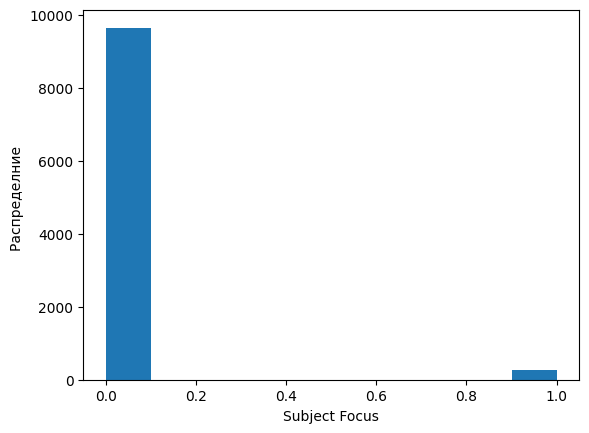

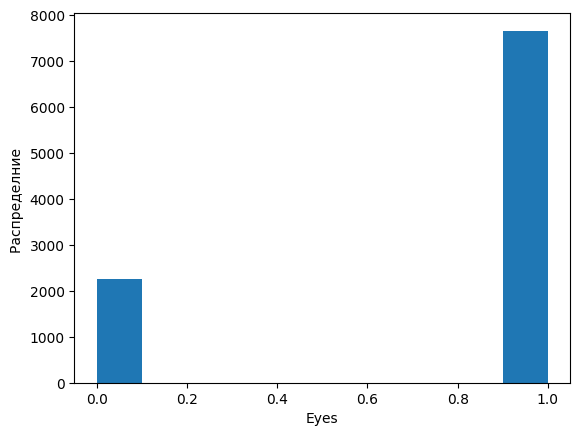

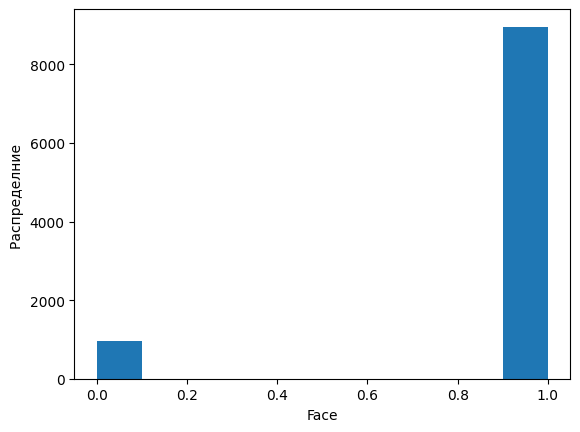

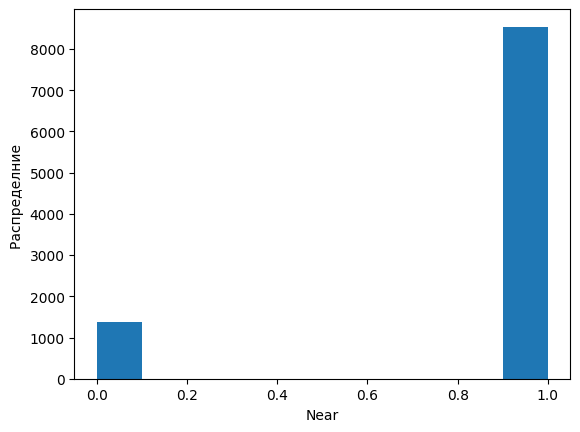

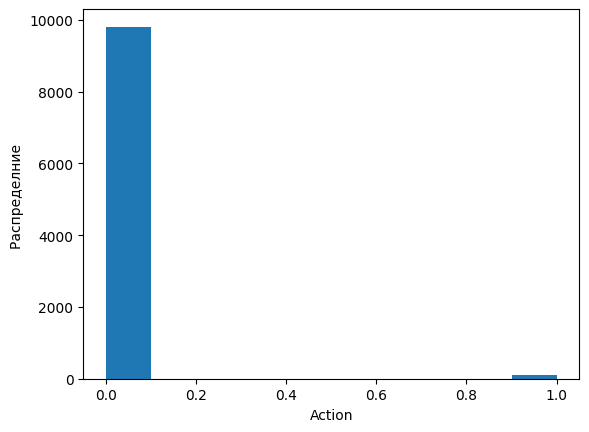

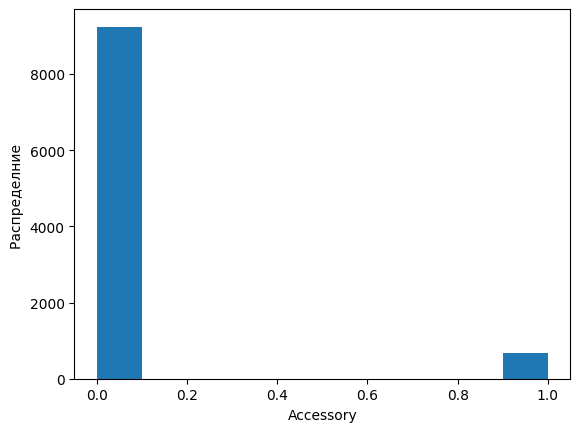

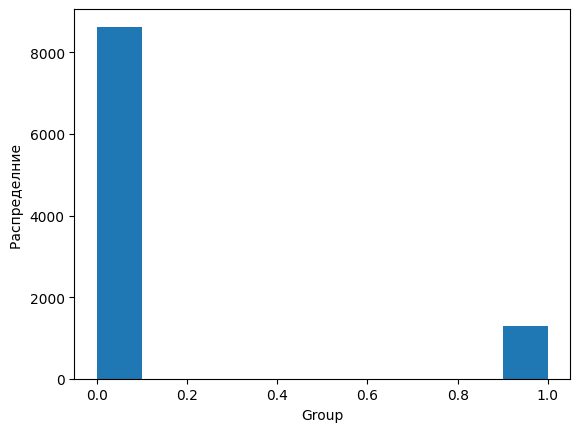

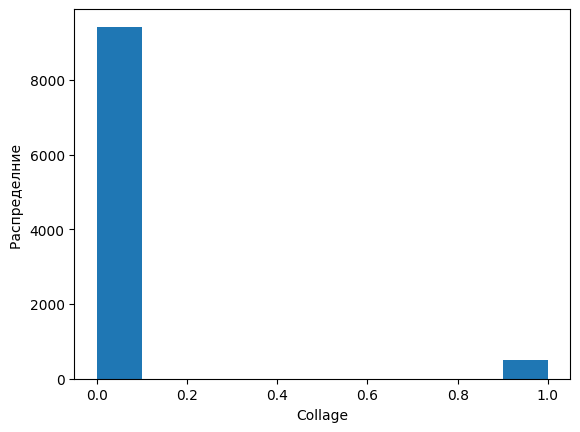

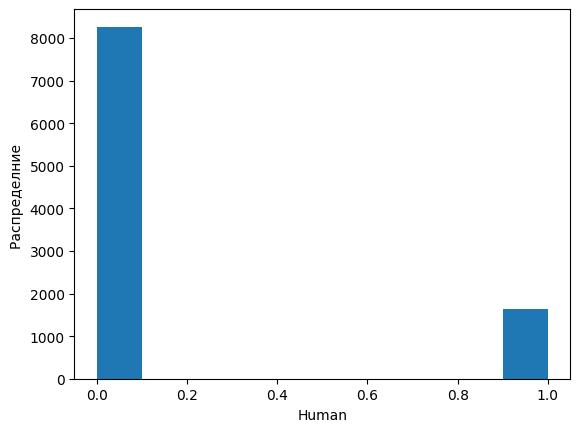

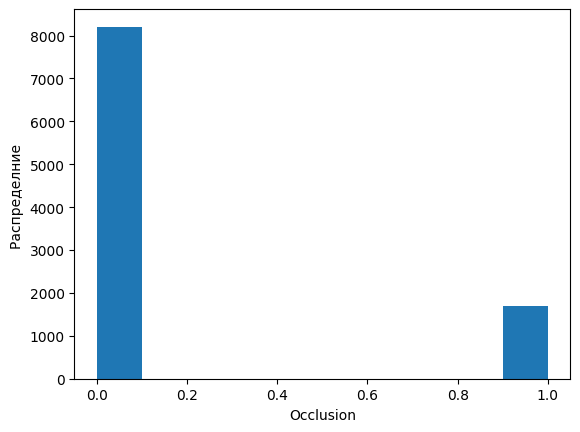

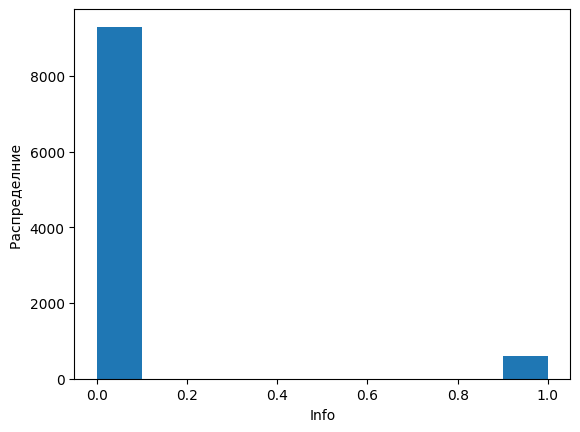

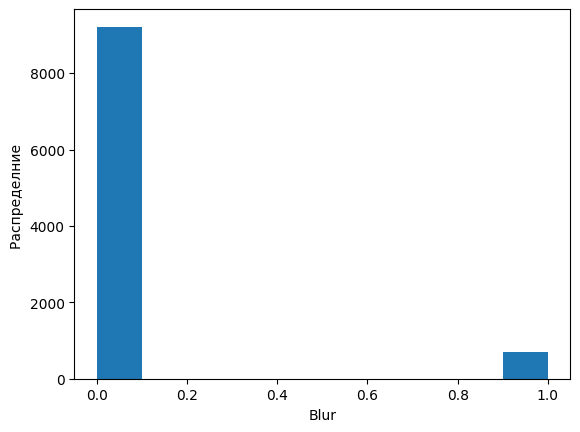

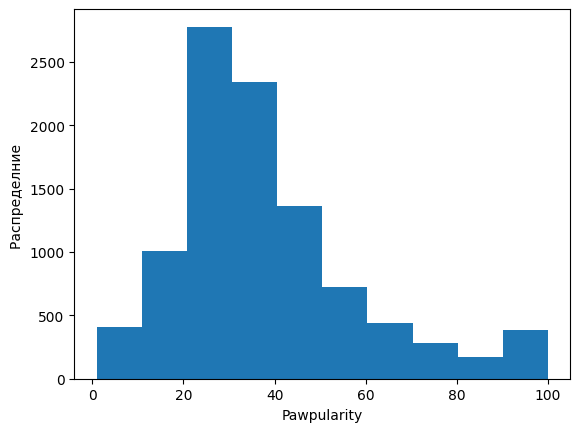

In [12]:
for col in num_cols:
    plt.hist(train[col])

    plt.xlabel(col)
    plt.ylabel('Распределние ')
    

    plt.show()

Accessory        0.013287

Group            0.016469

Blur            -0.023540

# Feature engineering

In [13]:
def featurize(df):
    df['Accessory2']=df['Accessory']*df['Accessory']
    df['Group2']=df['Group']*df['Group']
    df['Blur2']=df['Blur']*df['Blur']
    df['Blur_Accessory']=df['Blur']*df['Accessory']
    df['Group_Blur']=df['Group']*df['Blur']
    df['Accessory_Group']=df['Accessory']*df['Group']
    df['All']=df['Accessory']*df['Group']*df['Blur']
    

    return df

In [14]:
train_data=featurize(train_data)

eval_data=featurize(eval_data)


test=featurize(test)

# Datasets for all experiments 

In [15]:
IMG_SIZE=224

In [16]:
train_transforms = v2.Compose([
    #v2.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.75, 1.33),
     #                    interpolation=InterpolationMode.BILINEAR, antialias=True),
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.RandomHorizontalFlip(0.5),
    #v2.RandomApply([v2.Affine(degrees=10, translate=(0.02, 0.02), scale=(0.95, 1.05))], p=0.25),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    #v2.RandomGrayscale(p=0.05),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #v2.RandomErasing(p=0.25, scale=(0.02, 0.10), ratio=(0.3, 3.3))
])



In [17]:
eval_transforms = v2.Compose([
    #v2.Resize(int(IMG_SIZE * 1.14), antialias=True),
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    #v2.CenterCrop(IMG_SIZE),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [18]:
class PetDataset(Dataset):
    def __init__(self, df, img_dir, transforms, is_train):
        self.df=df
        self.img_dir=img_dir
        self.transforms=transforms
        self.is_train=is_train
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row=self.df.iloc[idx]
        img_name=row['Id']
        img_file=os.path.join(self.img_dir, f'{img_name}.jpg')
        image=Image.open(img_file).convert('RGB')

        if self.transforms is not None:
            image=self.transforms(image)

        if self.is_train:
            label=torch.tensor(row['Pawpularity'], dtype=torch.float32)
            return {
                'image':image,
                'label':label
            }
        else:
            return {
                'image':image
            }
        
        

In [19]:
train_dataset=PetDataset(train_data, train_img_dir, train_transforms, is_train=True)
eval_dataset=PetDataset(eval_data, train_img_dir, eval_transforms, is_train=True)

# DataLoaders

# BATCH_SIZE

In [20]:
BATCH_SIZE=32

In [21]:
train_dataloader=DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_dataloader=DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False )


# Modeling

## Visual model 

In [22]:
model_name='swin_base_patch4_window7_224' # tf_efficientnet_b3_ns 

model=timm.create_model(model_name, pretrained=True, num_classes=1).to(device)

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

# NUM_EPOCHS

In [23]:
NUM_EPOCHS=5

In [24]:
#0.01 * (effective_batch/256)

In [25]:
accum_steps=1

In [26]:
effective_batch=BATCH_SIZE/accum_steps

In [27]:
base_lr=0.01 * (effective_batch/256)

In [28]:
criterion=torch.nn.SmoothL1Loss(beta=1.0)
#optimizer=torch.optim.SGD(model.parameters(), lr=base_lr,)
#SequentialLR
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,          # or 2e-4
    weight_decay=1e-2
)


In [29]:
total_steps=NUM_EPOCHS*len(train_dataloader)
warmup_steps=0.05*total_steps

In [30]:
scheduler1=torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1e-3, end_factor=1.00, total_iters=warmup_steps,)
scheduler2=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps - warmup_steps, eta_min=base_lr*0.05)
scheduler=torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[warmup_steps])


In [31]:
ema_alpha = 0.98

In [32]:
for epoch in range(NUM_EPOCHS):
    pbar_train=tqdm(train_dataloader, desc=f'Training {epoch}/{NUM_EPOCHS}: ', leave=True)
    train_se_sum = 0.0
    train_count  = 0
    model.train()
    loss_ema = None
    
    for step, batch in enumerate(pbar_train):
        
        X=batch['image'].to(device)
        y=batch['label'].to(device)
        optimizer.zero_grad()

        logits=model(X).squeeze(-1)
        loss=criterion(logits, y)
        loss.backward()

        train_se_sum += torch.nn.functional.mse_loss(logits, y, reduction='sum').item()
        train_count  += y.numel()
        

        rmse_so_far   = math.sqrt(train_se_sum / max(1, train_count))
        loss_ema      = loss.item() if loss_ema is None else (ema_alpha*loss_ema + (1-ema_alpha)*loss.item())
        lr            = optimizer.param_groups[0]['lr']
        if step % 10 == 0:
            pbar_train.set_postfix({
                "loss": f"{loss_ema:.4f}",
                "rmse": f"{rmse_so_far:.4f}",
                "lr":   f"{lr:.2e}",
            }, refresh=False)

        optimizer.step()
        scheduler.step()
        
    train_rmse = math.sqrt(train_se_sum / max(1, train_count))

    model.eval()
    val_se_sum, val_count = 0.0, 0
    pbar_eval=tqdm(eval_dataloader, desc='Evaluation: ', leave=True)
    with torch.no_grad():
        for step, batch in enumerate(pbar_eval):
            X=batch['image'].to(device)
            y=batch['label'].to(device)

            logits=model(X).squeeze(-1)
            loss=criterion(logits, y)

            val_se_sum += torch.nn.functional.mse_loss(logits, y, reduction='sum').item()
            val_count  += y.numel()

            rmse_so_far = math.sqrt(val_se_sum / max(1, val_count))

            if step % 10 == 0:
                pbar_eval.set_postfix_str(f"rmse={rmse_so_far:.4f}", refresh=False)
                
    val_rmse = math.sqrt(val_se_sum / max(1, val_count))
        
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | train RMSE: {train_rmse:.5f} | val RMSE: {val_rmse:.5f}")    
        
        
                

Training 0/5:   0%|          | 0/264 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Evaluation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1/5 | train RMSE: 23.50154 | val RMSE: 21.39649


Training 1/5:   0%|          | 0/264 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/5 | train RMSE: 21.12042 | val RMSE: 21.81803


Training 2/5:   0%|          | 0/264 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/5 | train RMSE: 21.14447 | val RMSE: 21.06802


Training 3/5:   0%|          | 0/264 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/5 | train RMSE: 20.99040 | val RMSE: 20.62810


Training 4/5:   0%|          | 0/264 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/5 | train RMSE: 20.19650 | val RMSE: 19.87418


## Catboost over only table data 

In [33]:
X_train=train_data.drop(columns=['Pawpularity', 'Id'])
y_train=train_data['Pawpularity']

In [34]:
X_eval=eval_data.drop(columns=['Pawpularity', 'Id'])
y_eval=eval_data['Pawpularity']

In [35]:
#X_train, X_eval, y_train, y_eval=train_test_split(X, y, test_size=0.2, random_state=seed)

In [36]:
catboost_model=CatBoostRegressor(
    iterations=1000,
    learning_rate=0.03,
    depth=8, 
    loss_function='RMSE',
    
    eval_metric='RMSE',
    l2_leaf_reg=2,
    
    verbose=100,
    task_type='GPU',
    
)

In [37]:
catboost_model.fit(X_train, y_train, eval_set=(X_eval, y_eval), early_stopping_rounds=600)

0:	learn: 20.5336324	test: 20.9085718	best: 20.9085718 (0)	total: 13.9s	remaining: 3h 51m 29s
100:	learn: 20.4492308	test: 20.8990874	best: 20.8952398 (64)	total: 14.8s	remaining: 2m 11s
200:	learn: 20.4251837	test: 20.9062539	best: 20.8952398 (64)	total: 15.5s	remaining: 1m 1s
300:	learn: 20.4192453	test: 20.9093628	best: 20.8952398 (64)	total: 16.2s	remaining: 37.6s
400:	learn: 20.4139942	test: 20.9119045	best: 20.8952398 (64)	total: 16.8s	remaining: 25.1s
500:	learn: 20.4104107	test: 20.9148428	best: 20.8952398 (64)	total: 17.4s	remaining: 17.4s
600:	learn: 20.4092876	test: 20.9159681	best: 20.8952398 (64)	total: 18s	remaining: 11.9s
bestTest = 20.89523979
bestIteration = 64
Shrink model to first 65 iterations.


# Gathering stuff from these 

In [38]:
'''
def extract_embeddings(model, dataloader):
    model.eval()
    emb_list=[]
    with torch.no_grad():
        pbar=tqdm(dataloader, desc='Extracting embeddings: ', leave=False)
        for batch in pbar:
            X=batch['image'].to(device)
            feats=model.forward_features(X)
            emb=model.global_pool(feats)
            emb=torch.nn.functional.normalize(emb, dim=1)
            emb_list.append(emb.cpu())
    return np.concatenate(emb_list, axis=0) 
            
    
'''

"\ndef extract_embeddings(model, dataloader):\n    model.eval()\n    emb_list=[]\n    with torch.no_grad():\n        pbar=tqdm(dataloader, desc='Extracting embeddings: ', leave=False)\n        for batch in pbar:\n            X=batch['image'].to(device)\n            feats=model.forward_features(X)\n            emb=model.global_pool(feats)\n            emb=torch.nn.functional.normalize(emb, dim=1)\n            emb_list.append(emb.cpu())\n    return np.concatenate(emb_list, axis=0) \n            \n    \n"

In [39]:
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
# from sklearn.cluster import MiniBatchKMeans   # если захочешь unsup-кластеры

# ===================== 1) EMBEDDINGS =====================

def extract_embeddings(vision_model, dataloader, device):
    """
    Прогоняем даталоадер через vision-модель и возвращаем (N, D) numpy.
    Работает и с timm, где global_pool = 'avg'.
    """
    vision_model.eval()
    all_embs = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Extracting embeddings', leave=False)
        for batch in pbar:
            # подстрой под свой даталоадер
            if isinstance(batch, dict):
                x = batch['image'].to(device)
            else:
                x = batch[0].to(device)

            # 1) фичи
            feats = vision_model.forward_features(x)  # timm-style

            # 2) pooled -> emb
            gp = getattr(vision_model, "global_pool", None)
            if callable(gp):
                # редкий случай, когда это реально функция
                emb = gp(feats)
            else:
                # большинство timm: feats = [B, C, H, W] или [B, C]
                if feats.ndim == 4:
                    emb = torch.nn.functional.adaptive_avg_pool2d(feats, 1).flatten(1)
                else:
                    # уже [B, C]
                    emb = feats

            # 3) normalize
            emb = torch.nn.functional.normalize(emb, dim=1)
            all_embs.append(emb.cpu())

    all_embs = torch.cat(all_embs, dim=0).numpy().astype('float32')
    return all_embs


# ===================== 2) KNN по ЭМБЕДАМ (геометрия + индексы) =====================

def l2norm(x, eps=1e-12):
    x = x.astype(np.float32)
    n = np.linalg.norm(x, axis=1, keepdims=True) + eps
    return x / n

def knn_geom_features_train_test(train_emb, test_emb, k=32):
    """
    Делаем kNN по train_emb, считаем геометрию и ДЛЯ ТРЕЙНА возвращаем соседей БЕЗ себя.
    Возврат:
      train_feats: (N_train, F)
      test_feats:  (N_test, F)
      train_idxs: (N_train, k-1) — соседей без себя
      test_idxs:  (N_test, k)
      colnames: list[str]
    """
    train_emb = l2norm(train_emb)
    test_emb  = l2norm(test_emb)

    nn = NearestNeighbors(n_neighbors=k, metric='cosine')
    nn.fit(train_emb)

    # --- train ---
    d_tr, idx_tr = nn.kneighbors(train_emb, return_distance=True)
    sims_tr = 1.0 - d_tr

    # выкидываем self-neighbor (он всегда первый)
    sims_tr_wo = sims_tr[:, 1:]
    idx_tr_wo  = idx_tr[:, 1:]

    train_feats = []
    for sims_i in sims_tr_wo:
        maxsim  = sims_i[0]
        meansim = sims_i.mean()
        stdsim  = sims_i.std()
        kthsim  = sims_i[-1]
        ratio15 = sims_i[0] / (sims_i[4] + 1e-6) if sims_i.shape[0] >= 5 else sims_i[0]
        train_feats.append([maxsim, meansim, stdsim, kthsim, ratio15])
    train_feats = np.array(train_feats, dtype=np.float32)

    # --- test ---
    d_te, idx_te = nn.kneighbors(test_emb, return_distance=True)
    sims_te = 1.0 - d_te

    test_feats = []
    for sims_i in sims_te:
        maxsim  = sims_i[0]
        meansim = sims_i.mean()
        stdsim  = sims_i.std()
        kthsim  = sims_i[-1]
        ratio15 = sims_i[0] / (sims_i[4] + 1e-6) if sims_i.shape[0] >= 5 else sims_i[0]
        test_feats.append([maxsim, meansim, stdsim, kthsim, ratio15])
    test_feats = np.array(test_feats, dtype=np.float32)

    colnames = ['knn_maxsim', 'knn_meansim', 'knn_stdsim', 'knn_kthsim', 'knn_ratio1_5']
    return train_feats, test_feats, idx_tr_wo, idx_te, colnames


# ===================== 3) АГРЕГАЦИИ ТАБЛИЧКИ ПО ЭТИМ KNN =====================

def agg_tabular_over_knn(train_df: pd.DataFrame,
                         test_df: pd.DataFrame,
                         train_knn_idx: np.ndarray,
                         test_knn_idx: np.ndarray,
                         num_cols=None,
                         cat_cols=None):
    """
    Для каждого объекта берём его соседей (по эмбедам) и считаем аггрегаты
    ПО ТАБЛИЧНЫМ фичам соседей.
    """
    if num_cols is None: num_cols = []
    if cat_cols is None: cat_cols = []

    N_train = train_df.shape[0]
    N_test  = test_df.shape[0]

    feat_dict_train = {}
    feat_dict_test  = {}

    # -------- NUMERIC --------
    for col in num_cols:
        tr_vals = train_df[col].values
        te_vals = test_df[col].values

        # train
        tr_neighbors_vals = tr_vals[train_knn_idx]             # (N_train, k-1)
        feat_dict_train[f'{col}_knn_mean'] = tr_neighbors_vals.mean(1)
        feat_dict_train[f'{col}_knn_std']  = tr_neighbors_vals.std(1)
        feat_dict_train[f'{col}_knn_min']  = tr_neighbors_vals.min(1)
        feat_dict_train[f'{col}_knn_max']  = tr_neighbors_vals.max(1)
        # отношение к себе
        feat_dict_train[f'{col}_knn_mean_div_self'] = feat_dict_train[f'{col}_knn_mean'] / (tr_vals + 1e-6)

        # test
        te_neighbors_vals = tr_vals[test_knn_idx]              # ВАЖНО: тест берём у ТРЕЙНА
        feat_dict_test[f'{col}_knn_mean'] = te_neighbors_vals.mean(1)
        feat_dict_test[f'{col}_knn_std']  = te_neighbors_vals.std(1)
        feat_dict_test[f'{col}_knn_min']  = te_neighbors_vals.min(1)
        feat_dict_test[f'{col}_knn_max']  = te_neighbors_vals.max(1)
        feat_dict_test[f'{col}_knn_mean_div_self'] = feat_dict_test[f'{col}_knn_mean'] / (te_vals + 1e-6)

    # -------- CATEGORICAL --------
    for col in cat_cols:
        tr_vals = train_df[col].values
        te_vals = test_df[col].values

        # train
        tr_neighbors_vals = tr_vals[train_knn_idx]  # (N_train, k-1)
        mode_list = []
        mode_share_list = []
        nunique_list = []
        same_as_self_list = []

        for i in range(N_train):
            row = tr_neighbors_vals[i]
            uniq, cnt = np.unique(row, return_counts=True)
            top_idx = cnt.argmax()
            mode_val = uniq[top_idx]
            mode_share = cnt[top_idx] / row.shape[0]
            nunique = uniq.shape[0]
            same_as_self = int(mode_val == tr_vals[i])

            mode_list.append(mode_val)
            mode_share_list.append(mode_share)
            nunique_list.append(nunique)
            same_as_self_list.append(same_as_self)

        feat_dict_train[f'{col}_knn_mode'] = np.array(mode_list)
        feat_dict_train[f'{col}_knn_mode_share'] = np.array(mode_share_list, dtype=np.float32)
        feat_dict_train[f'{col}_knn_nunique'] = np.array(nunique_list, dtype=np.float32)
        feat_dict_train[f'{col}_knn_same_as_self'] = np.array(same_as_self_list, dtype=np.int8)

        # test (соседи теста — это train)
        te_neighbors_vals = tr_vals[test_knn_idx]
        mode_list = []
        mode_share_list = []
        nunique_list = []
        same_as_self_list = []

        for i in range(N_test):
            row = te_neighbors_vals[i]
            uniq, cnt = np.unique(row, return_counts=True)
            top_idx = cnt.argmax()
            mode_val = uniq[top_idx]
            mode_share = cnt[top_idx] / row.shape[0]
            nunique = uniq.shape[0]
            same_as_self = int(mode_val == te_vals[i])

            mode_list.append(mode_val)
            mode_share_list.append(mode_share)
            nunique_list.append(nunique)
            same_as_self_list.append(same_as_self)

        feat_dict_test[f'{col}_knn_mode'] = np.array(mode_list)
        feat_dict_test[f'{col}_knn_mode_share'] = np.array(mode_share_list, dtype=np.float32)
        feat_dict_test[f'{col}_knn_nunique'] = np.array(nunique_list, dtype=np.float32)
        feat_dict_test[f'{col}_knn_same_as_self'] = np.array(same_as_self_list, dtype=np.int8)

    df_train_knn = pd.DataFrame(feat_dict_train, index=train_df.index)
    df_test_knn  = pd.DataFrame(feat_dict_test,  index=test_df.index)
    return df_train_knn, df_test_knn


# Doing catboost over embeddings+table data 

In [40]:
# ===== 0) обычные табличные данные
X_train = train_data.drop(columns=['Pawpularity', 'Id'])
y_train = train_data['Pawpularity']

X_eval  = eval_data.drop(columns=['Pawpularity', 'Id'])
y_eval  = eval_data['Pawpularity']

# ===== 1) эмбеды
train_emb = extract_embeddings(model, train_dataloader, device)
eval_emb  = extract_embeddings(model, eval_dataloader, device)

# ===== 2) kNN по эмбедам: геометрия + индексы
train_knn_geom, eval_knn_geom, train_knn_idx, eval_knn_idx, knn_geom_cols = \
    knn_geom_features_train_test(train_emb, eval_emb, k=32)

df_train_knn_geom = pd.DataFrame(train_knn_geom, columns=knn_geom_cols, index=X_train.index)
df_eval_knn_geom  = pd.DataFrame(eval_knn_geom,  columns=knn_geom_cols, index=X_eval.index)

# ===== 3) аггрегируем ТАБЛИЧНЫЕ фичи по этим же соседям
num_cols = [c for c in X_train.columns if X_train[c].dtype != 'object']
cat_cols = [c for c in X_train.columns if X_train[c].dtype == 'object']

df_train_knn_tab, df_eval_knn_tab = agg_tabular_over_knn(
    X_train, X_eval,
    train_knn_idx, eval_knn_idx,
    num_cols=num_cols,
    cat_cols=cat_cols
)

# ===== 4) склеиваем всё
X_train_full = pd.concat([X_train, df_train_knn_geom, df_train_knn_tab], axis=1)
X_eval_full  = pd.concat([X_eval,  df_eval_knn_geom,  df_eval_knn_tab],  axis=1)

# ===== 5) если хочешь ещё и raw embedding как embedding_feature
X_train_full['embed'] = train_emb.tolist()
X_eval_full['embed']  = eval_emb.tolist()

from catboost import CatBoostRegressor

model_final = CatBoostRegressor(
    iterations=4000,
    learning_rate=0.03,
    depth=8,
    loss_function='RMSE',
    eval_metric='RMSE',
    l2_leaf_reg=2,
    verbose=100,
    task_type='GPU',
)

model_final.fit(
    X_train_full,
    y_train,
    eval_set=(X_eval_full, y_eval),
    embedding_features=['embed'],   # если хочешь кормить эмбед прямо
    early_stopping_rounds=1050
)


0:	learn: 20.5321056	test: 20.9090372	best: 20.9090372 (0)	total: 3.22s	remaining: 3h 34m 30s
100:	learn: 20.2050527	test: 20.9026167	best: 20.9005183 (66)	total: 5.46s	remaining: 3m 30s
200:	learn: 19.9662274	test: 20.9137646	best: 20.9005183 (66)	total: 7.68s	remaining: 2m 25s
300:	learn: 19.8064897	test: 20.9293713	best: 20.9005183 (66)	total: 9.71s	remaining: 1m 59s
400:	learn: 19.5543327	test: 20.9552705	best: 20.9005183 (66)	total: 12s	remaining: 1m 47s
500:	learn: 19.3468919	test: 20.9783189	best: 20.9005183 (66)	total: 14.3s	remaining: 1m 39s
600:	learn: 19.1268319	test: 20.9878115	best: 20.9005183 (66)	total: 16.6s	remaining: 1m 33s
700:	learn: 18.9472264	test: 20.9981095	best: 20.9005183 (66)	total: 18.9s	remaining: 1m 29s
800:	learn: 18.7682659	test: 21.0283098	best: 20.9005183 (66)	total: 21.3s	remaining: 1m 24s
900:	learn: 18.6302162	test: 21.0518891	best: 20.9005183 (66)	total: 23.5s	remaining: 1m 20s
1000:	learn: 18.4898360	test: 21.0746244	best: 20.9005183 (66)	total: 2

In [41]:
import torch
import os

# suppose you have this:
# model = swin_model  # timm.create_model('swin_base_patch4_window7_224', pretrained=True)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

save_dir = "./models"
os.makedirs(save_dir, exist_ok=True)

swin_path = os.path.join(save_dir, "swin_backbone.pth")

# ✅ recommended: save only weights
torch.save(model.state_dict(), swin_path)

print(f"Swin weights saved to {swin_path}")


Swin weights saved to ./models/swin_backbone.pth


In [42]:
from catboost import CatBoostRegressor

# you already trained:
# model_final = CatBoostRegressor(...)
# model_final.fit(...)

catboost_path = "./models/catboost_final.cbm"
model_final.save_model(catboost_path)
print(f"CatBoost model saved to {catboost_path}")


CatBoost model saved to ./models/catboost_final.cbm


In [43]:
import json

meta = {
    "model_name": "swin_base_patch4_window7_224",
    "embed_dim": 1024,   # или model.num_features
}
with open("./models/swin_meta.json", "w") as f:
    json.dump(meta, f, indent=2)


# Идея Дани с SSL !!!!!!!


In [44]:
'''

def extract_embeddings(model, dataloader):
    model.eval()
    emb_list=[]
    with torch.no_grad():
        pbar=tqdm(dataloader, desc='Extracting embeddings: ', leave=False)
        for batch in pbar:
            X=batch['image'].to(device)
            feats=model.forward_features(X)
            emb=model.global_pool(feats)
            emb=torch.nn.functional.normalize(emb, dim=1)
            emb_list.append(emb.cpu())
    return np.concatenate(emb_list, axis=0)
            
   
'''    

"\n\ndef extract_embeddings(model, dataloader):\n    model.eval()\n    emb_list=[]\n    with torch.no_grad():\n        pbar=tqdm(dataloader, desc='Extracting embeddings: ', leave=False)\n        for batch in pbar:\n            X=batch['image'].to(device)\n            feats=model.forward_features(X)\n            emb=model.global_pool(feats)\n            emb=torch.nn.functional.normalize(emb, dim=1)\n            emb_list.append(emb.cpu())\n    return np.concatenate(emb_list, axis=0)\n            \n   \n"

In [45]:
def class_centroid(embeddings, labels, num_class):
    D = embeddings.size(1)
    centroids = torch.zeros(num_class, D, dtype=embeddings.dtype)
    for c in range(num_class):
        mask = (labels == c)
        if mask.any():
            centroids[c] = embeddings[mask].mean(0)
        else:
            centroids[c] = torch.zeros(D, dtype=embeddings.dtype)

    centroids = torch.nn.functional.normalize(centroids, dim=1)
    return centroids
                
        
         
    
    

In [46]:
def sim_to_class_centroids(embeddings, centroids):
    if not torch.is_tensor(embeddings):
        embeddings = torch.from_numpy(embeddings)
    if not torch.is_tensor(centroids):
        centroids = torch.from_numpy(centroids)

    embeddings = torch.nn.functional.normalize(embeddings, dim=1)
    centroids  = torch.nn.functional.normalize(centroids,  dim=1)

    sims = embeddings @ centroids.T
    return sims
    

In [47]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def l2norm(x, eps=1e-12):
    x = x.astype(np.float32)
    n = np.linalg.norm(x, axis=1, keepdims=True) + eps
    return x / n

def knn_geom_features(emb, k=32):
   
    emb = l2norm(emb)

    nn = NearestNeighbors(n_neighbors=k, metric='cosine')
    nn.fit(emb)
    dists, idxs = nn.kneighbors(emb, return_distance=True)
    sims = 1.0 - dists

    feats = []
    for sims_i in sims:
        maxsim  = sims_i[0]
        meansim = sims_i.mean()
        stdsim  = sims_i.std()
        kthsim  = sims_i[-1]
        ratio15 = sims_i[0] / (sims_i[4] + 1e-6) if k >= 5 else sims_i[0]
        feats.append([maxsim, meansim, stdsim, kthsim, ratio15])

    feats = np.array(feats, dtype=np.float32)
    colnames = ['knn_maxsim', 'knn_meansim', 'knn_stdsim', 'knn_kthsim', 'knn_ratio1_5']
    return feats, colnames
    

In [48]:
'''



import numpy as np
from sklearn.cluster import MiniBatchKMeans
import torch

# 1. нормализация
def l2norm(x, eps=1e-12):
    x = x.astype(np.float32)
    n = np.linalg.norm(x, axis=1, keepdims=True) + eps
    return x / n

# 2. учим кластеры на train-эмбедах
def fit_embed_clusters(train_emb, n_clusters=64, batch_size=1024, random_state=42):
    """
    train_emb: (N_train, D) numpy/torch
    returns: kmeans, centers (numpy, l2-normalized)
    """
    if torch.is_tensor(train_emb):
        train_emb = train_emb.cpu().numpy()
    train_emb = train_emb.astype(np.float32)

    km = MiniBatchKMeans(
        n_clusters=n_clusters,
        batch_size=batch_size,
        random_state=random_state
    )
    km.fit(train_emb)

    centers = km.cluster_centers_.astype(np.float32)
    centers = l2norm(centers)      # для cosine
    return km, centers

# 3. фичи по центрам (как “по классам”)
def proto_features_from_centers(emb, centers, tau=0.1):
    """
    emb: (N, D) numpy/torch
    centers: (K, D) numpy/torch
    возвращает:
      sims_all: (N, K) косинусы (если нужно)
      feats: (N, 4) [max_sim, gap, entropy, argmax]
    """
    if torch.is_tensor(emb):
        emb = emb.cpu().numpy()
    if torch.is_tensor(centers):
        centers = centers.cpu().numpy()

    emb = l2norm(emb)
    centers = l2norm(centers)

    # cosine: (N, D) @ (D, K) -> (N, K)
    sims = emb @ centers.T   # [N, K]

    # 1) max_sim
    max_sim = sims.max(axis=1)

    # 2) gap = top1 - top2
    top2 = np.sort(sims, axis=1)[:, -2:]   # [..., second, first]
    gap = top2[:, 1] - top2[:, 0]

    # 3) entropy по softmax(cos / tau)
    # tau маленький -> энтропия маленькая, если объект "узкий"
    logits = sims / tau
    logits = logits - logits.max(axis=1, keepdims=True)
    probs = np.exp(logits)
    probs = probs / probs.sum(axis=1, keepdims=True)
    entropy = -(probs * np.log(probs + 1e-9)).sum(axis=1)

    # 4) argmax (номер "псевдокласса")
    cluster_id = sims.argmax(axis=1)

    feats = np.stack([max_sim, gap, entropy, cluster_id.astype(np.float32)], axis=1)
    colnames = ['emb_proto_max_sim', 'emb_proto_gap', 'emb_proto_entropy', 'emb_proto_cluster_id']
    return sims, feats, colnames

# 4. обёртка: train -> fit -> featurize train+test
def make_unsupervised_embed_features(train_emb, test_emb, n_clusters=64, tau=0.1):
    """
    train_emb, test_emb: (N, D)
    return:
      train_feats: (N_train, F)
      test_feats:  (N_test, F)
      colnames: list[str]
    """
    # 1) учим кластеры только на train
    kmeans, centers = fit_embed_clusters(train_emb, n_clusters=n_clusters)

    # 2) делаем фичи для train
    _, train_feats, colnames = proto_features_from_centers(train_emb, centers, tau=tau)

    # 3) делаем фичи для test
    _, test_feats, _ = proto_features_from_centers(test_emb, centers, tau=tau)

    # + можно добавить расстояние до своего центра из kmeans
    train_labels = kmeans.predict(train_emb)
    test_labels  = kmeans.predict(test_emb)

    train_cent = centers[train_labels]  # (N_train, D)
    test_cent  = centers[test_labels]

    # евклидово расстояние в исходном пространстве (до нормализации)
    train_dist = np.linalg.norm(train_emb - train_cent, axis=1, keepdims=True)
    test_dist  = np.linalg.norm(test_emb  - test_cent,  axis=1, keepdims=True)

    # приклеим
    train_feats = np.concatenate([train_feats, train_dist], axis=1)
    test_feats  = np.concatenate([test_feats,  test_dist],  axis=1)
    colnames = colnames + ['emb_proto_dist_to_own_center']

    return train_feats, test_feats, colnames
'''

'\n\n\n\nimport numpy as np\nfrom sklearn.cluster import MiniBatchKMeans\nimport torch\n\n# 1. нормализация\ndef l2norm(x, eps=1e-12):\n    x = x.astype(np.float32)\n    n = np.linalg.norm(x, axis=1, keepdims=True) + eps\n    return x / n\n\n# 2. учим кластеры на train-эмбедах\ndef fit_embed_clusters(train_emb, n_clusters=64, batch_size=1024, random_state=42):\n    """\n    train_emb: (N_train, D) numpy/torch\n    returns: kmeans, centers (numpy, l2-normalized)\n    """\n    if torch.is_tensor(train_emb):\n        train_emb = train_emb.cpu().numpy()\n    train_emb = train_emb.astype(np.float32)\n\n    km = MiniBatchKMeans(\n        n_clusters=n_clusters,\n        batch_size=batch_size,\n        random_state=random_state\n    )\n    km.fit(train_emb)\n\n    centers = km.cluster_centers_.astype(np.float32)\n    centers = l2norm(centers)      # для cosine\n    return km, centers\n\n# 3. фичи по центрам (как “по классам”)\ndef proto_features_from_centers(emb, centers, tau=0.1):\n    """\n 